# Cloud-Optimized ICESat-2

## Cloud-Optimized vs Cloud-Native

Recall from [03-cloud-optimized-data-access.ipynb](./03-cloud-optimized-data-access.ipynb) that we can make any HDF5 file cloud-optimized by restructuring the file so that all the metadata is in one place and chunks are "not too big" and "not too small". However, as users of the data, not archivers, we don't control how the file is generated and distributed, so if we're restructuring the data we might want to go with something even better - a **"cloud-native"** format.

:::{important} Cloud-Native Formats
Cloud-native formats are formats that were designed specifically to be used in a cloud environment. This usually means that metadata and indexes for data is separated from metadata in a way that allows for logical dataset access across multiple files. In other words, it is fast to open a large dataset and access just the parts of it that you need.
:::

:::{warning}
Generating cloud-native formats is non-trivial.
:::

:::{seealso}
* https://eo-college.org/topics/cloud-native-data-formats/
* https://guide.cloudnativegeo.org
:::

## Geoparquet

To demonstrate one such cloud-native format, geoparquet, we have generated a geoparquet store (see [atl08_parquet.ipynb](./atl08_parquet_files/atl08_parquet.ipynb)) for the ATL08 dataset and will visualize it using a very performant geospatial vector visualization library, [`lonboard`](https://developmentseed.org/lonboard/latest/).

:::{seealso} Resource on Geoparquet
* https://guide.cloudnativegeo.org/geoparquet/
* https://geoparquet.org/
:::

## Demo

In [3]:
import geopandas as gpd
import pyarrow.parquet as pq
from pyarrow import fs
import pyarrow.dataset as ds
from shapely import wkb

s3  = fs.S3FileSystem(region="us-west-2", anonymous=True)
dataset = pq.ParquetDataset("eodc-public/atl08_parquet/", filesystem=s3,
                            partitioning="hive", filters=[('year', '>=', 2021), ('year', '<=', 2021), ('month', '>=', 11), ('month', '<=', 11)])
table = dataset.read(columns=["h_canopy", "geometry"])
df = table.to_pandas()
df['geometry'] = df['geometry'].apply(wkb.loads)


gdf = gpd.GeoDataFrame(df, geometry='geometry')
null_value = gdf['h_canopy'].max() 
gdf_filtered = gdf.loc[gdf['h_canopy'] != null_value]
gdf_filtered

,h_canopy,geometry
0,17.453796,POINT (-52.29471 -26.99078)
1,19.481018,POINT (-52.29480 -26.98988)
2,21.340637,POINT (-52.29490 -26.98898)
3,28.491821,POINT (-52.29500 -26.98808)
4,41.652527,POINT (-52.29510 -26.98719)
...,...,...
1870365,48.303154,POINT (-44.09986 -2.68297)
1870374,23.472631,POINT (-44.10197 -2.66132)
1870423,11.832104,POINT (-44.11124 -2.57115)
1870462,3.599800,POINT (-44.12907 -2.38984)


<Axes: >

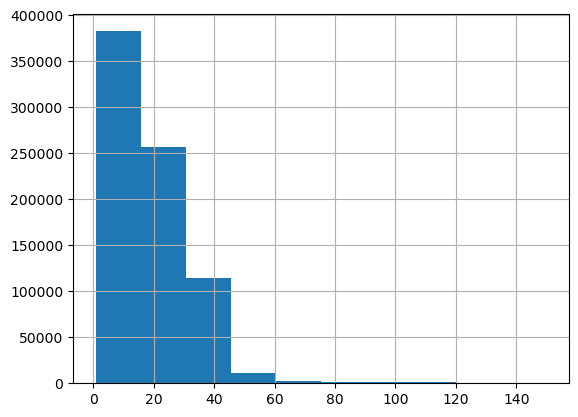

In [17]:
gdf_filtered['h_canopy'].hist()

In [24]:
%%time
from lonboard import Map, ScatterplotLayer
from lonboard.colormap import apply_continuous_cmap
from palettable.colorbrewer.diverging import BrBG_10

min_bound = 0
max_bound = 60
h_canopy = gdf_filtered['h_canopy']
h_canopy_normalized = (h_canopy - min_bound) / (max_bound - min_bound)

layer = ScatterplotLayer.from_geopandas(gdf_filtered, radius_min_pixels=0.5)
layer.get_fill_color = apply_continuous_cmap(h_canopy_normalized, BrBG_10, alpha=0.7)

m = Map(layer)
m.set_view_state(zoom=2)
m

/srv/conda/envs/notebook/lib/python3.11/site-packages/lonboard/_geoarrow/ops/reproject.py:23: UserWarning: No CRS exists on data. If no data is shown on the map, double check that your CRS is WGS84.
  warn(


CPU times: user 1.1 s, sys: 167 ms, total: 1.27 s
Wall time: 1.26 s


Map(layers=[ScatterplotLayer(get_fill_color=<pyarrow.lib.FixedSizeListArray object at 0x7fd15490a9e0>
[
  [
  …